In [41]:
# Install a pip package in the current Jupyter kernel
import sys
#!{sys.executable} -m pip install mne-connectivity

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
import gc
import pyarrow
import openpyxl
from glob import glob
import numpy as np
import scipy as sp
import sklearn
import statistics, math
import random as rd
import pandas as pd
import dataframe_image as dfi
pd.options.display.float_format = '{:,.2f}'.format

from math import sqrt, ceil

from sklearn import metrics
from sklearn import decomposition, cluster
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from scipy.spatial.distance import correlation
from IPython.display import display

In [4]:
import mne
#import mne_connectivity

from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap, annotate_muscle_zscore, peak_finder,
                               find_eog_events, find_ecg_events, ica_find_ecg_events, find_bad_channels_maxwell)
from mne.time_frequency import (tfr_array_multitaper, psd_array_multitaper, csd_array_multitaper, csd_array_morlet)

from mne_connectivity import seed_target_indices, spectral_connectivity_epochs, spectral_connectivity_time

print(mne.__file__)
print(mne.__version__)

C:\Users\Lenovo\anaconda3\lib\site-packages\mne\__init__.py
1.3.1


In [5]:
import plotly.graph_objects as go
from gtda.time_series import SingleTakensEmbedding, TakensEmbedding, takens_embedding_optimal_parameters
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import BettiCurve, Scaler, Filtering, Amplitude, PersistenceEntropy, NumberOfPoints
from gtda.plotting import plot_point_cloud


In [6]:
# Configure the graphics engine

import matplotlib.pyplot as plt
plt.rc('figure', max_open_warning=200)
%matplotlib notebook
#%matplotlib inline
#%matplotlib qt

In [7]:
import seaborn as sns
# Apply the default theme
sns.set_theme()

# Loading data

In [8]:
#==============================================
# Input main data information
#==============================================

# Number of the subject for analysis
SUBJ_NUM = 3

# For m1 and m3 suffix for EEG record number 
SUFFIX = '_2'

# Is surrogate EEG record
SURR = True
#SURR = False

In [9]:
# Initialize path variables for main folders

print(os.getcwd())

if (SUBJ_NUM < 10):
    subj_dir_name = 'm0' + str(SUBJ_NUM) + SUFFIX
else:
    subj_dir_name = 'm' + str(SUBJ_NUM) + SUFFIX
    
init_dir_name = 'm' + str(SUBJ_NUM) + SUFFIX

# Path for loading EEG raw data
init_dir_path = os.path.join(os.getcwd(), 'work_data')

# Path for saving epoch data and features
ft_dir_path = os.path.join(os.getcwd(), 'features', subj_dir_name)

# Create destination folder if not exists
if not os.path.exists(ft_dir_path):
    os.mkdir(ft_dir_path)

print(init_dir_path)
print(ft_dir_path)

C:\Users\Lenovo\PycharmProjects\Tibet
C:\Users\Lenovo\PycharmProjects\Tibet\work_data
C:\Users\Lenovo\PycharmProjects\Tibet\features\m03_2_surr


In [42]:
#Fp_chan=['Fpz', 'Fp1', 'Fp2','Fz']
#C_chan=['Cz', 'C3','C4','C1', 'C2']
#P_chan=['Pz', 'P3', 'P4', 'P8', 'P7', 'P6', 'P5', 'P1', 'P2']
#PO_chan=['POz', 'PO3', 'PO7','PO4', 'PO8'] 
#O_chan= ['Oz', 'O1', 'O2']
#Cz_chan=['CPz','FCz']

ECG_ch = ['ecg']
resp_ch = ['resp']
sound_ch = ['Sound']
accel_ch = ['Accelerometer']

data_raw = mne.io.read_raw_edf(os.path.join(init_dir_path, init_dir_name + r"_40.edf"), preload=True)

sampling_rate = data_raw.info['sfreq']

print(data_raw.info.ch_names)
print(data_raw.info)

#data_eog = data.copy().pick_channels(EOG_ch)
data_ecg = data_raw.copy().pick_channels(ECG_ch)
#data_ecg.plot(scalings = dict(eeg=100e-4), duration=10)
data_resp = data_raw.copy().pick_channels(resp_ch)
#data_resp.plot(scalings = dict(eeg=100e-3), duration=10)

data_raw.drop_channels(['ecg', 'resp', 'Sound', 'Accelerometer'])
#data_raw.rename_channels(lambda s: s[:-1].upper()+s[-1])
data_raw.rename_channels({'Ft7':'FT7', 'Fc3':'FC3', 'Fcz':'FCz', 'Fc4':'FC4', 'Ft8':'FT8', 'Tp7':'TP7', 'Cp3':'CP3', 
                          'Cpz':'CPz', 'Cp4':'CP4', 'Tp8':'TP8', 'Po3':'PO3', 'Poz':'POz', 'Po4':'PO4', 'Po7':'PO7', 
                          'Po8':'PO8'})
data_raw.set_montage('standard_1020')
#data.set_channel_types(change_types)
print(data_raw.ch_names)
#data_raw.plot(duration=10)
print()
data_raw

Extracting EDF parameters from C:\Users\Lenovo\PycharmProjects\Tibet\work_data\m3_2_40.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 663499  =      0.000 ...  1326.998 secs...
['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'Ft7', 'Fc3', 'Fcz', 'Fc4', 'Ft8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'Tp7', 'Cp3', 'Cpz', 'Cp4', 'Tp8', 'A1', 'T5', 'P3', 'Pz', 'P4', 'T6', 'A2', 'P5', 'Po3', 'Poz', 'Po4', 'P6', 'Po7', 'O1', 'Oz', 'O2', 'Po8', 'ecg', 'Sound', 'Accelerometer', 'resp']
<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fpz, Fp2, F7, F3, Fz, F4, F8, Ft7, Fc3, Fcz, Fc4, Ft8, T3, ...
 chs: 44 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 70.0 Hz
 meas_date: 2020-02-29 11:59:03 UTC
 nchan: 44
 projs: []
 sfreq: 500.0 Hz
>
['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FT7', 'FC3', 'FCz', 'FC4', 'FT8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'TP7', 'CP3', 'CPz', 'CP4', 'TP8', 'A1', 'T5', 'P3', 'Pz', 'P4', 'T6', 'A2', 'P5

<RawEDF | m3_2_40.edf, 40 x 663500 (1327.0 s), ~202.5 MB, data loaded>

<IPython.core.display.Javascript object>


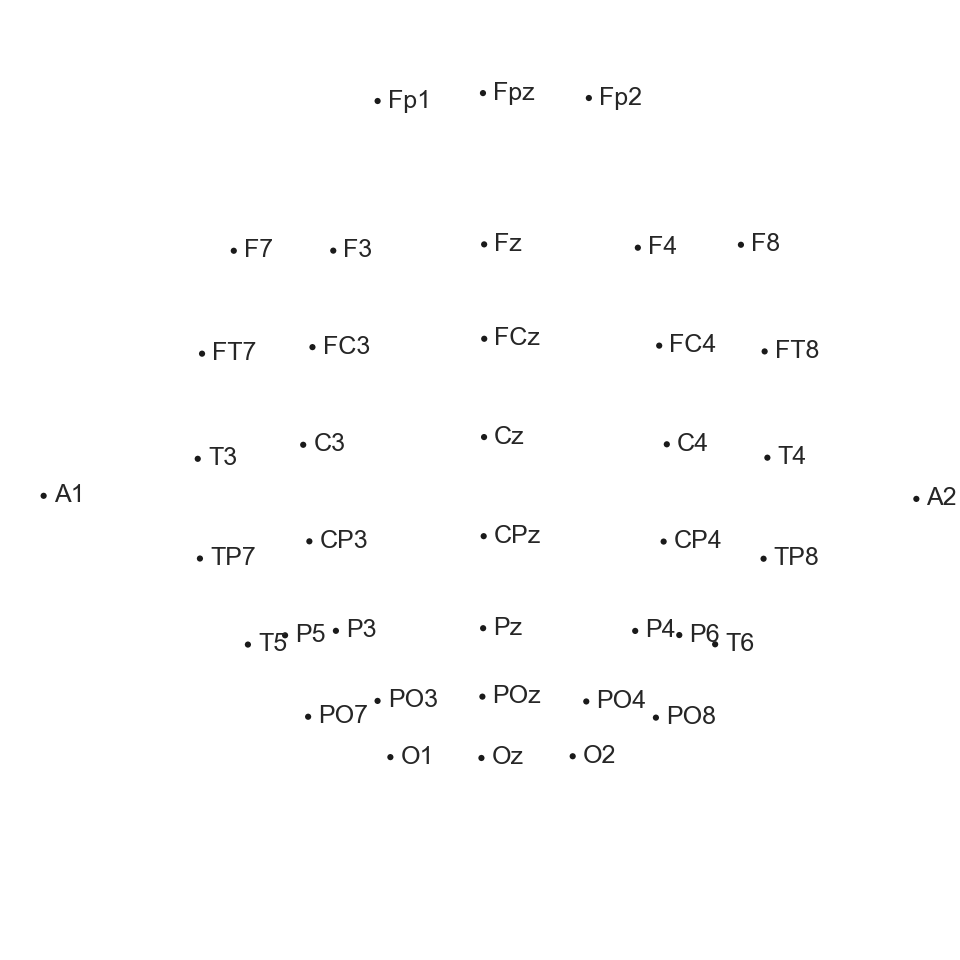

In [44]:
data_raw.plot_sensors(ch_type='eeg', show_names=True)
print()

In [49]:
# Re-referencing raw data (common average reference)
bands = [(0.9, 4, 'Delta (0.9-4 Hz)'), (4, 8, 'Theta (4-8 Hz)'), (8, 14, 'Alpha (8-14 Hz)'), 
         (14, 25, 'Beta (14-25 Hz)'), (25, 40, 'Gamma (25-40 Hz)')]

data_raw_filt = data_raw.copy().filter(l_freq=bands[0][0], h_freq=bands[-1][1])
#fig_orig = data_raw_filt.plot(duration=20)

rr_data_raw, ref_ch = mne.set_eeg_reference(data_raw, ref_channels='average', copy=True, projection=False, ch_type='auto')
rr_data_raw_filt = rr_data_raw.copy().filter(l_freq=bands[0][0], h_freq=bands[-1][1])
#fig_reref = rr_data_raw_filt.plot(duration=20)

# Correlation matrix for raw filtered data
#matr_corr_ts_raw = np.corrcoef(data_raw.copy().crop(tmax=20).get_data())
#df_matr_corr_ts_raw = pd.DataFrame(matr_corr_ts_raw, index = data_raw.ch_names, columns = data_raw.ch_names)
#display_corr_matrix(df_matr_corr_ts_raw)
#matr_corr_ts_rr_raw = np.corrcoef(rr_data_raw.copy().crop(tmax=20).get_data())
#df_matr_corr_ts_rr_raw = pd.DataFrame(matr_corr_ts_rr_raw, index = data_raw.ch_names, columns = data_raw.ch_names)
#display_corr_matrix(df_matr_corr_ts_rr_raw)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1835 samples (3.670 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


EEG channel type selected for re-referencing


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    2.4s finished


Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1835 samples (3.670 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    2.3s finished


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)


<IPython.core.display.Javascript object>


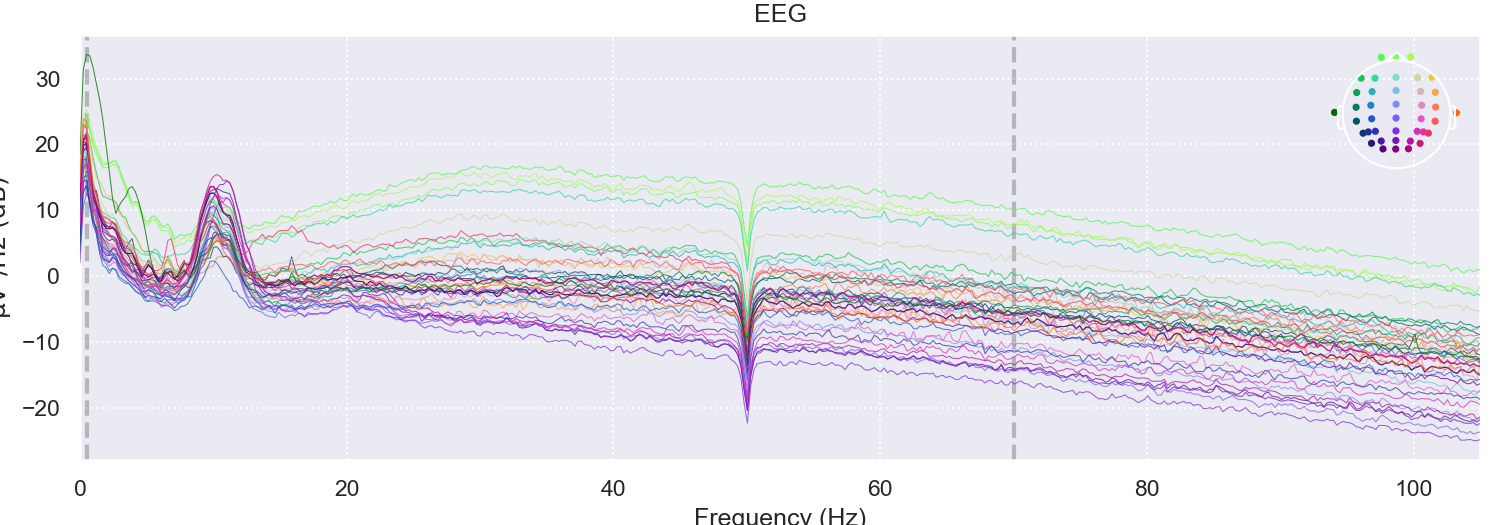

In [15]:
rr_data_raw.plot_psd(fmin=0, fmax=105)
print()

# Preprocessing data

## ICA preparation 

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Fitting ICA to data using 40 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.8s finished


Selecting by explained variance: 23 components
Fitting ICA took 57.7s.
Creating RawArray with float64 data, n_channels=23, n_times=651001
    Range : 3000 ... 654000 =      6.000 ...  1308.000 secs
Ready.


<IPython.core.display.Javascript object>


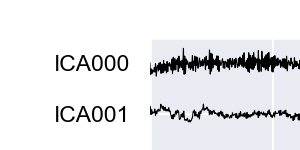

<IPython.core.display.Javascript object>


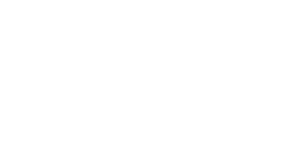

<IPython.core.display.Javascript object>


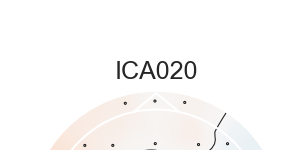

[<MNEFigure size 975x967 with 20 Axes>, <MNEFigure size 585x260.5 with 3 Axes>]

In [46]:
rr_data_ica = rr_data_raw.copy()
#rr_data_ica.info['bads']=["F4","F8"]
#rr_data_ica.interpolate_bads(reset_bads=True)

#rr_data_ica.filter(l_freq=4., h_freq=None) # for m10
rr_data_ica.filter(l_freq=1., h_freq=40) # for m8 & m3_2

rr_ica = ICA(n_components=.99, max_iter='auto', random_state=97)
rr_ica.fit(rr_data_ica)

rr_ica.plot_sources(rr_data_ica)
rr_ica.plot_components()

In [47]:
# Exclude ECG channel (re-referenced data)

#rr_ica.exclude = [3] # for m10 (ECG)
#rr_ica.exclude = [0,2,10] # for m8 ([2,10]-ECG, [0,3]-EOG)
rr_ica.exclude = [1,4,5] # for m3 ([1,5]-EOG, [4]-T3)

reref_data = rr_data_raw.copy()
rr_ica.apply(reref_data)

#reref_data.plot()
#reref_data.plot_psd()

#rr_data_notch = reref_data.copy().notch_filter([50])
#rr_data_notch.plot_psd()#fmin=0, fmax=105)
print()

Applying ICA to Raw instance
    Transforming to ICA space (23 components)
    Zeroing out 3 ICA components
    Projecting back using 40 PCA components



# Epoching data

In [1]:
gc.collect()

NameError: name 'gc' is not defined

## Global variables & filtering

In [21]:
# Frequency bands

bands = [(0.9, 4, 'Delta (0.9-4 Hz)', 'D'), (4, 8, 'Theta (4-8 Hz)', 'T'), (8, 14, 'Alpha (8-14 Hz)', 'A'), 
         (14, 25, 'Beta (14-25 Hz)', 'B'), (25, 40, 'Gamma (25-40 Hz)', 'G')]

str_freq = [bands[i][3] for i in range(len(bands))]
#str_freq_rr = ['r'+_str for _str in str_freq]
str_freq_rr = str_freq
n_freq = len(str_freq_rr)


In [22]:
# Localization by scalp regions

regions = [(['Fp1','Fp2','Fpz'], 'Fp', 'Pre-frontal'), (['F7','F3','FT7','FC3'], 'LF', 'Left Frontal'), 
           (['Fz','FCz'], 'MF', 'Midline Frontal'), (['F4','F8','FC4','FT8'], 'RF', 'Right Frontal'),
           (['T3','TP7','T5'], 'LT', 'Left Temporal'), (['T4','TP8','T6'], 'RT', 'Right Temporal'), 
           (['C3','CP3'], 'LC', 'Left Central'), (['Cz','CPz'], 'MC', 'Midline Central'), (['C4','CP4'], 'RC', 'Right Central'),
           (['P3','P5'], 'LP', 'Left Parietal'), (['Pz'], 'MP', 'Midline Parietal'), (['P4','P6'], 'RP', 'Right Parietal'), 
           (['PO3','PO7','O1'], 'LO', 'Left Occipital'), (['POz','Oz'], 'MO', 'Midline Occipital'), 
           (['PO4','PO8','O2'], 'RO', 'Right Occipital')]
regions_plt = [(['Fp1','Fp2','Fpz'], 'Fp', 'Pre-frontal'), (['F7','F3','FT7','FC3'], 'LF', 'Left Frontal'), 
           (['Fz','FCz'], 'MF', 'Midline Frontal'), (['F4','F8','FC4','FT8'], 'RF', 'Right Frontal'),
           (['T3','TP7','T5'], 'LT', 'Left Temporal'), (['T4','TP8','T6'], 'RT', 'Right Temporal'), 
           (['C3','CP3','Cz','CPz','C4','CP4'], 'Cen', 'Central'), (['P3','P5','Pz','P4','P6'], 'Par', 'Parietal'), 
           (['PO3','PO7','O1','POz','Oz','PO4','PO8','O2'], 'Occ', 'Occipital')]

n_regions = len(regions)
n_regions_plt = len(regions_plt)

In [51]:
# Filtering raw_data

data_rr_filt = reref_data.copy().filter(l_freq=bands[0][0], h_freq=bands[-1][1])
data_rr_filt_spectr = []
for i in range(len(bands)):
    data_rr_filt_spectr.append(reref_data.copy().filter(l_freq=bands[i][0], h_freq=bands[i][1]))
data_rr_filt

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1835 samples (3.670 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.9s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.9 - 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.90
- Lower transition bandwidth: 0.90 Hz (-6 dB cutoff frequency: 0.45 Hz)
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 1835 samples (3.670 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.3s finished


Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.4s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 825 samples (1.650 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.5s finished


Setting up band-pass filter from 14 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 12.25 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 473 samples (0.946 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    2.5s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 265 samples (0.530 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    2.8s finished


<RawEDF | m3_2_40.edf, 40 x 651001 (1302.0 s), ~198.7 MB, data loaded>

## Epoching

In [26]:
gc.collect()

30

In [27]:
# Epochs by fixed length events, duration 1s, overlap 0.2s (re-referenced)

#fix_1s_events_rr = mne.make_fixed_length_events(data_rr_filt, start=0.5, duration=1., overlap=0.2) # for m10
fix_1s_events_rr = mne.make_fixed_length_events(data_rr_filt, start=0.5, duration=1.) # for m8
kwargs = dict(baseline=None, tmin=-0.5, tmax=0.5, preload=True)

epochs_fix_1s_rr = mne.Epochs(data_rr_filt, fix_1s_events_rr.astype(int), **kwargs)
epochs_fix_1s_rr = epochs_fix_1s_rr[2:-2] #remove first and last 2sec due to possible filtering artefacts

print(fix_1s_events_rr.shape)
print(epochs_fix_1s_rr)
print(epochs_fix_1s_rr.get_data().shape)
#print(epochs_fix_1s_rr.events)

epochs_fix_rr_spectr = []
for i in range(len(bands)):   
    epochs_fix_rr_spectr.append(mne.Epochs(data_rr_filt_spectr[i], fix_1s_events_rr.astype(int), **kwargs))
    epochs_fix_rr_spectr[i] = epochs_fix_rr_spectr[i][2:-2] 

#epochs_fix_1s_rr.average().plot_joint()
print()

Not setting metadata
1304 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1304 events and 501 original time points ...
0 bad epochs dropped
(1304, 3)
<Epochs |  1300 events (all good), -0.5 - 0.5 sec, baseline off, ~198.8 MB, data loaded,
 '1': 1300>
(1300, 40, 501)
Not setting metadata
1304 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1304 events and 501 original time points ...
2 bad epochs dropped
Not setting metadata
1304 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1304 events and 501 original time points ...
2 bad epochs dropped
Not setting metadata
1304 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1304 events and 501 original time points ...
2 bad epochs dropped
Not setting metadata
1304 matching events

No projector specified for this dataset. Please consider the method self.add_proj.


<IPython.core.display.Javascript object>


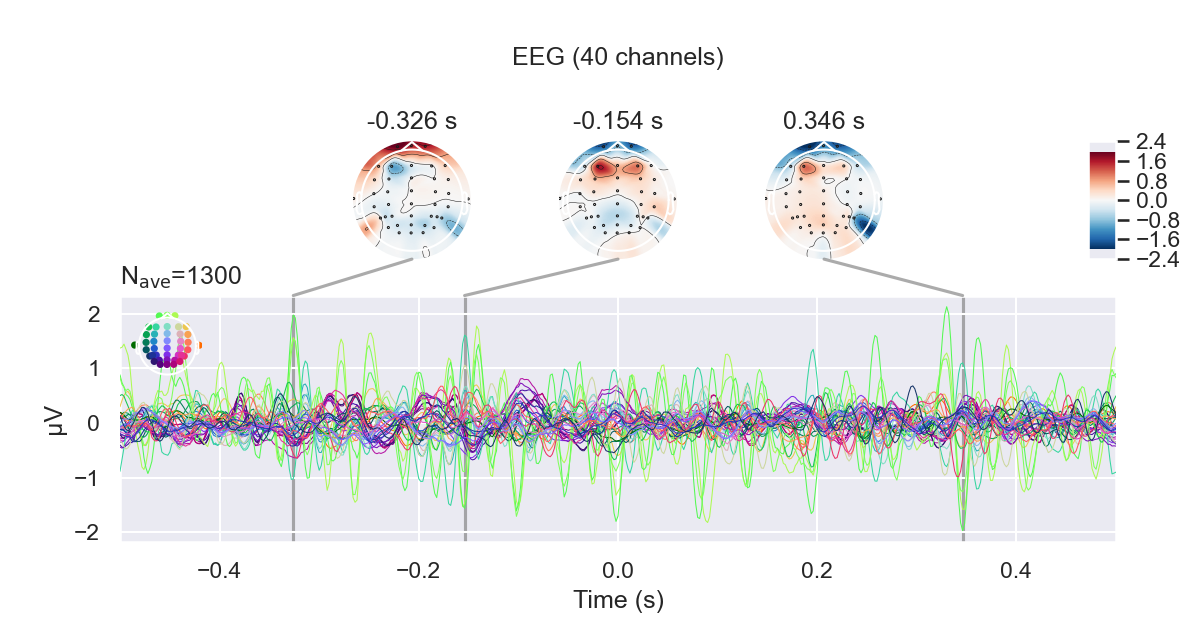

In [81]:
epochs_fix_1s_rr.average().plot_joint()
print()

In [28]:
# Global variables

ch_names = epochs_fix_1s_rr.ch_names
n_freq = len(str_freq_rr)
n_channels = len(ch_names)

n_samples = epochs_fix_1s_rr.__len__()
n_times = len(epochs_fix_1s_rr.get_data()[0,0,:])

print(ch_names)
  

['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FT7', 'FC3', 'FCz', 'FC4', 'FT8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'TP7', 'CP3', 'CPz', 'CP4', 'TP8', 'A1', 'T5', 'P3', 'Pz', 'P4', 'T6', 'A2', 'P5', 'PO3', 'POz', 'PO4', 'P6', 'PO7', 'O1', 'Oz', 'O2', 'PO8']


# Extract features

## PSD features

In [29]:
# Calculating PSD for re-referenced epochs (Multitaper)

kwargs = dict(fmin=bands[0][0], fmax=bands[-1][1], sfreq=sampling_rate, bandwidth=None, adaptive=True, n_jobs=1)

rr_psd_mtaper, rr_freq_mtaper = psd_array_multitaper(epochs_fix_1s_rr.get_data(), **kwargs)
freq_masks = [(fmin < rr_freq_mtaper) & (rr_freq_mtaper < fmax) for (fmin, fmax, _, _) in bands]
loc_masks = [[ch_names[i] in reg for i in range(n_channels)] for (reg, _, _) in regions]
loc_plt_masks = [[ch_names[i] in reg for i in range(n_channels)] for (reg, _, _) in regions_plt]
print(rr_freq_mtaper)
print(rr_psd_mtaper.shape)

ft_psd_spectr_raw = np.array([np.mean(rr_psd_mtaper[:,:, _freq_mask], axis=2) for _freq_mask in freq_masks]).transpose(1,2,0)
ft_psd_sp_loc_raw = np.array([np.mean(ft_psd_spectr_raw[:,_mask,:], axis=1) for _mask in loc_masks]).transpose(1,0,2)
ft_psd_sp_plt_raw = np.array([np.mean(ft_psd_spectr_raw[:,_mask,:], axis=1) for _mask in loc_plt_masks]).transpose(1,0,2)
ft_psd_sp_all_raw = np.mean(ft_psd_spectr_raw, axis=1)

ft_psd_spectr_db = 10 * np.log10(ft_psd_spectr_raw) # Convert psd to dB format
ft_psd_sp_loc_db = 10 * np.log10(ft_psd_sp_loc_raw) # Convert psd to dB 
ft_psd_sp_plt_db = 10 * np.log10(ft_psd_sp_plt_raw) # Convert psd to dB format
ft_psd_sp_all_db = 10 * np.log10(ft_psd_sp_all_raw) # Convert psd to dB format

df_ft_psd_raw = pd.DataFrame()
df_ft_psd_db = pd.DataFrame()
df_ft_psd_loc_raw = pd.DataFrame()
df_ft_psd_loc_db = pd.DataFrame()
df_ft_psd_plt_raw = pd.DataFrame()
df_ft_psd_plt_db = pd.DataFrame()
df_ft_psd_all_raw = pd.DataFrame()
df_ft_psd_all_db = pd.DataFrame()

for i in range(n_freq):
    for j in range(n_channels):
        df_ft_psd_raw[str_freq_rr[i]+'_psd_'+ch_names[j]] = ft_psd_spectr_raw[:,j,i]
        df_ft_psd_db[str_freq_rr[i]+'_psd_'+ch_names[j]] = ft_psd_spectr_db[:,j,i]
    for j in range(n_regions):    
        df_ft_psd_loc_raw[str_freq_rr[i]+'_psd_'+regions[j][1]] = ft_psd_sp_loc_raw[:,j,i]
        df_ft_psd_loc_db[str_freq_rr[i]+'_psd_'+regions[j][1]] = ft_psd_sp_loc_db[:,j,i]
    for j in range(n_regions_plt):    
        df_ft_psd_plt_raw[str_freq_rr[i]+'_psd_'+regions_plt[j][1]] = ft_psd_sp_plt_raw[:,j,i]
        df_ft_psd_plt_db[str_freq_rr[i]+'_psd_'+regions_plt[j][1]] = ft_psd_sp_plt_db[:,j,i]
    df_ft_psd_all_raw[str_freq_rr[i]+'_psd_All'] = ft_psd_sp_all_raw[:,i]
    df_ft_psd_all_db[str_freq_rr[i]+'_psd_All'] = ft_psd_sp_all_db[:,i]
#print(len(df_ft_psd_db.columns))

# Scaling dB re-referenced data
ft_psd_db_sc = StandardScaler().fit_transform(df_ft_psd_db.to_numpy())
df_ft_psd_db_sc = pd.DataFrame(ft_psd_db_sc, columns=df_ft_psd_db.columns)
ft_psd_loc_db_sc = StandardScaler().fit_transform(df_ft_psd_loc_db.to_numpy())
df_ft_psd_loc_db_sc = pd.DataFrame(ft_psd_loc_db_sc, columns=df_ft_psd_loc_db.columns)
ft_psd_all_db_sc = StandardScaler().fit_transform(df_ft_psd_all_db.to_numpy())
df_ft_psd_all_db_sc = pd.DataFrame(ft_psd_all_db_sc, columns=df_ft_psd_all_db.columns)

    Using multitaper spectrum estimation with 7 DPSS windows
[ 0.99800399  1.99600798  2.99401198  3.99201597  4.99001996  5.98802395
  6.98602794  7.98403194  8.98203593  9.98003992 10.97804391 11.9760479
 12.9740519  13.97205589 14.97005988 15.96806387 16.96606786 17.96407186
 18.96207585 19.96007984 20.95808383 21.95608782 22.95409182 23.95209581
 24.9500998  25.94810379 26.94610778 27.94411178 28.94211577 29.94011976
 30.93812375 31.93612774 32.93413174 33.93213573 34.93013972 35.92814371
 36.9261477  37.9241517  38.92215569 39.92015968]
(1300, 40, 40)


## PSD Indices

In [33]:
df_ft_psd_ind = pd.DataFrame()
df_ft_psd_ind_plt = pd.DataFrame()

str_psd_ind = ['T_D','A_D','A_T','A_DT','B_D','B_T','B_A','B_DT','B_TA','G_D','G_T','G_A','G_B','G_DT','G_TA','G_AB']

df_ft_psd_ind_loc = pd.DataFrame()
df_ft_psd_ind_plt = pd.DataFrame()
df_ft_psd_ind_all = pd.DataFrame()

# Indices per region (averaged PSD)
for _r in range(n_regions):
    for ind in str_psd_ind:
        if (len(ind)==3):
            df_ft_psd_ind_loc[ind+'_psd_'+regions[_r][1]] = (df_ft_psd_loc_raw[ind[0]+'_psd_'+regions[_r][1]] / 
                                                             df_ft_psd_loc_raw[ind[2]+'_psd_'+regions[_r][1]])
        elif (len(ind)==4):
            df_ft_psd_ind_loc[ind+'_psd_'+regions[_r][1]] = (df_ft_psd_loc_raw[ind[0]+'_psd_'+regions[_r][1]] / 
                                                            (df_ft_psd_loc_raw[ind[2]+'_psd_'+regions[_r][1]]+
                                                             df_ft_psd_loc_raw[ind[3]+'_psd_'+regions[_r][1]]))
# Indices per region for plotting (averaged PSD)
for _r in range(n_regions_plt):
    for ind in str_psd_ind:
        if (len(ind)==3):
            df_ft_psd_ind_plt[ind+'_psd_'+regions_plt[_r][1]] = (df_ft_psd_plt_raw[ind[0]+'_psd_'+regions_plt[_r][1]] / 
                                                                 df_ft_psd_plt_raw[ind[2]+'_psd_'+regions_plt[_r][1]])
        elif (len(ind)==4):
            df_ft_psd_ind_plt[ind+'_psd_'+regions_plt[_r][1]] = (df_ft_psd_plt_raw[ind[0]+'_psd_'+regions_plt[_r][1]] / 
                                                                (df_ft_psd_plt_raw[ind[2]+'_psd_'+regions_plt[_r][1]]+
                                                                 df_ft_psd_plt_raw[ind[3]+'_psd_'+regions_plt[_r][1]]))

# Indices for all channels averaged PSD
for ind in str_psd_ind:
    if (len(ind)==3):
        df_ft_psd_ind_all[ind+'_psd_All'] = (df_ft_psd_all_raw[ind[0]+'_psd_All'] / 
                                             df_ft_psd_all_raw[ind[2]+'_psd_All'])
    elif (len(ind)==4):
        df_ft_psd_ind_all[ind+'_psd_All'] = (df_ft_psd_all_raw[ind[0]+'_psd_All'] / 
                                            (df_ft_psd_all_raw[ind[2]+'_psd_All']+
                                             df_ft_psd_all_raw[ind[3]+'_psd_All']))


In [34]:
# Log-scaling PSD indices (dB format)
df_ft_psd_ind_loc_log = 10 * np.log10(df_ft_psd_ind_loc)
df_ft_psd_ind_plt_log = 10 * np.log10(df_ft_psd_ind_plt)
df_ft_psd_ind_all_log = 10 * np.log10(df_ft_psd_ind_all)

# No need to log-scale A|T & A|(D+T) for m10
#orig_col = [col for col in df_ft_psd_ind_loc.columns if ('A_T' in col) or ('A_DT' in col)]
#df_ft_psd_ind_loc_log[orig_col] = df_ft_psd_ind_loc[orig_col]
#orig_col = [col for col in df_ft_psd_ind_plt.columns if ('A_T' in col) or ('A_DT' in col)]
#df_ft_psd_ind_plt_log[orig_col] = df_ft_psd_ind_plt[orig_col]
#orig_col = [col for col in df_ft_psd_ind_all.columns if ('A_T' in col) or ('A_DT' in col)]
#df_ft_psd_ind_all_log[orig_col] = df_ft_psd_ind_all[orig_col]

# Scaling
ft_psd_ind_loc_sc = StandardScaler().fit_transform(df_ft_psd_ind_loc_log.to_numpy())
df_ft_psd_ind_loc_sc = pd.DataFrame(ft_psd_ind_loc_sc, columns=df_ft_psd_ind_loc_log.columns)
ft_psd_ind_all_sc = StandardScaler().fit_transform(df_ft_psd_ind_all_log.to_numpy())
df_ft_psd_ind_all_sc = pd.DataFrame(ft_psd_ind_all_sc, columns=df_ft_psd_ind_all_log.columns)


## Coherence & PLV features

In [35]:
# Averaging epochs by region
loc_masks = [[ch_names[i] in reg for i in range(n_channels)] for (reg, _, _) in regions]
loc_plt_masks = [[ch_names[i] in reg for i in range(n_channels)] for (reg, _, _) in regions_plt]

# Re-referenced data
ft_epochs = epochs_filt_rr.get_data()
ft_epochs_loc = np.array([np.mean(ft_epochs[:,_mask,:], axis=1) for _mask in loc_masks]).transpose(1,0,2)
ft_epochs_plt = np.array([np.mean(ft_epochs[:,_mask,:], axis=1) for _mask in loc_plt_masks]).transpose(1,0,2)

print(ft_epochs.shape)
print(ft_epochs_loc.shape)
print(ft_epochs_plt.shape)
#print(ch_names)

(1190, 40, 501)
(1190, 15, 501)
(1190, 9, 501)


In [36]:
# Calculating CSD (Cross-spectral densities), re-referenced data

ft_csd_matr_sp = []
ft_csd_matr_loc_sp = []
ft_csd_matr_plt_sp = []
kwargs = dict(fmin=bands[0][0], fmax=bands[-1][1], sfreq=sampling_rate, adaptive=True, n_jobs=1)

# Calculating CSD for each epoch (Multitaper)
for i in range(n_samples):
    csd_mtaper = csd_array_multitaper(ft_epochs[i].reshape((1, n_channels, n_times)), **kwargs)
    ft_csd_matr_sp.append([csd_mtaper.mean(fmin, fmax).get_data() for (fmin, fmax, _, _) in bands])
    print(i, np.array(ft_csd_matr_sp[i]).shape)

    csd_mtaper = csd_array_multitaper(ft_epochs_loc[i].reshape((1, n_regions, n_times)), **kwargs)
    ft_csd_matr_loc_sp.append([csd_mtaper.mean(fmin, fmax).get_data() for (fmin, fmax, _, _) in bands])
    print(i, np.array(ft_csd_matr_loc_sp[i]).shape)

    csd_mtaper = csd_array_multitaper(ft_epochs_plt[i].reshape((1, n_regions_plt, n_times)), **kwargs)
    ft_csd_matr_plt_sp.append([csd_mtaper.mean(fmin, fmax).get_data() for (fmin, fmax, _, _) in bands])
    print(i, np.array(ft_csd_matr_plt_sp[i]).shape)
    
ft_csd_matr_sp = np.array(ft_csd_matr_sp)
ft_csd_matr_loc_sp = np.array(ft_csd_matr_loc_sp)
ft_csd_matr_plt_sp = np.array(ft_csd_matr_plt_sp)

print(ft_csd_matr_sp.shape)
print(ft_csd_matr_loc_sp.shape)
print(ft_csd_matr_plt_sp.shape)

    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
0 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
0 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
0 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
3 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
3 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
3 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
4 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
4 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
4 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
5 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
5 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
5 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
6 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
6 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
6 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
7 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
7 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
7 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
8 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
8 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
8 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
9 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
9 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
9 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
10 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
10 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
10 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
11 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
11 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
11 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
12 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
12 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
12 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
13 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
13 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
13 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
14 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
14 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
14 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
15 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
15 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
15 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
16 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
16 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
16 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
17 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
17 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
17 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
18 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
18 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
18 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
19 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
19 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
19 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
20 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
20 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
20 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
21 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
21 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
21 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
22 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
22 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
22 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
23 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
23 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
23 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
24 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
24 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
24 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
25 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
25 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
25 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
26 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
26 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
26 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
27 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
27 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
27 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
28 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
28 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
28 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
29 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
29 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
29 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
30 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
30 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
30 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
31 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
31 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
31 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
32 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
32 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
32 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
33 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
33 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
33 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
34 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
34 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
34 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
35 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
35 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
35 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
36 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
36 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
36 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
37 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
37 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
37 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
38 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
38 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
38 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
39 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
39 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
39 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
40 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
40 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
40 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
41 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
41 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
41 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
42 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
42 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
42 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
43 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
43 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
43 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
44 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
44 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
44 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
45 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
45 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
45 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
46 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
46 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
46 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
47 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
47 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
47 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
48 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
48 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
48 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
49 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
49 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
49 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
50 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
50 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
50 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
51 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
51 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
51 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
52 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
52 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
52 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
53 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
53 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
53 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
54 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
54 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
54 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
55 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
55 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
55 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
56 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
56 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
56 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
57 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
57 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
57 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
58 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
58 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
58 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
59 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
59 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
59 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
60 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
60 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
60 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
61 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
61 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
61 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
62 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
62 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
62 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
63 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
63 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
63 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
64 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
64 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
64 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
65 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
65 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
65 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
66 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
66 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
66 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
67 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
67 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
67 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
68 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
68 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
68 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
69 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
69 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
69 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
70 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
70 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
70 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
71 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
71 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
71 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
72 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
72 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
72 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
73 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
73 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
73 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
74 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
74 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
74 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
75 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
75 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
75 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
76 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
76 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
76 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
77 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
77 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
77 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
78 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
78 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
78 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
79 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
79 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
79 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
80 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
80 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
80 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
81 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
81 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
81 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
82 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
82 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
82 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
83 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
83 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
83 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
84 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
84 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
84 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
85 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
85 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
85 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
86 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
86 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
86 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
87 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
87 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
87 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
88 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
88 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
88 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
89 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
89 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
89 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
90 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
90 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
90 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
91 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
91 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
91 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
92 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
92 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
92 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
93 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
93 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
93 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
94 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
94 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
94 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
95 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
95 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
95 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
96 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
96 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
96 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
97 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
97 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
97 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
98 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
98 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
98 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
99 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
99 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
99 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
100 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
100 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
100 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
101 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
101 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
101 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
102 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
102 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
102 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
103 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
103 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
103 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
104 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
104 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
104 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
105 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
105 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
105 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
106 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
106 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
106 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
107 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
107 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
107 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
108 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
108 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
108 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
109 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
109 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
109 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
110 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
110 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
110 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
111 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
111 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
111 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
112 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
112 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
112 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
113 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
113 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
113 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
114 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
114 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
114 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
115 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
115 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
115 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
116 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
116 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
116 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
117 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
117 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
117 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
118 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
118 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
118 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
119 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
119 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
119 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
120 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
120 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
120 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
121 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
121 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
121 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
122 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
122 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
122 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
123 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
123 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
123 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
124 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
124 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
124 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
125 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
125 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
125 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
126 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
126 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
126 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
127 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
127 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
127 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
128 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
128 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
128 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
129 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
129 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
129 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
130 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
130 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
130 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
131 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
131 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
131 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
132 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
132 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
132 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
133 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
133 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
133 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
134 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
134 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
134 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
135 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
135 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
135 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
136 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
136 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
136 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
137 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
137 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
137 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
138 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
138 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
138 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
139 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
139 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
139 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
140 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
140 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
140 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
141 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
141 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
141 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
142 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
142 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
142 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
143 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
143 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
143 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
144 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
144 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
144 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
145 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
145 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
145 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
146 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
146 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
146 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
147 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
147 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
147 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
148 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
148 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
148 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
149 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
149 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
149 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
150 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
150 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
150 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
151 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
151 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
151 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
152 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
152 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
152 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
153 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
153 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
153 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
154 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
154 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
154 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
155 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
155 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
155 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
156 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
156 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
156 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
157 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
157 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
157 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
158 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
158 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
158 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
159 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
159 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
159 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
160 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
160 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
160 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
161 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
161 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
161 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
162 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
162 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
162 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
163 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
163 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
163 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
164 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
164 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
164 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
165 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
165 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
165 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
166 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
166 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
166 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
167 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
167 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
167 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
168 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
168 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
168 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
169 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
169 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
169 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
170 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
170 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
170 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
171 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
171 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
171 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
172 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
172 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
172 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
173 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
173 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
173 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
174 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
174 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
174 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
175 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
175 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
175 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
176 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
176 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
176 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
177 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
177 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
177 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
178 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
178 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
178 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
179 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
179 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
179 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
180 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
180 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
180 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
181 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
181 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
181 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
182 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
182 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
182 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
183 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
183 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
183 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
184 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
184 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
184 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
185 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
185 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
185 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
186 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
186 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
186 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
187 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
187 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
187 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
188 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
188 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
188 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
189 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
189 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
189 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
190 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
190 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
190 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
191 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
191 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
191 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
192 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
192 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
192 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
193 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
193 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
193 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
194 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
194 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
194 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
195 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
195 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
195 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
196 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
196 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
196 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
197 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
197 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
197 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
198 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
198 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
198 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
199 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
199 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
199 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
200 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
200 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
200 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
201 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
201 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
201 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
202 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
202 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
202 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
203 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
203 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
203 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
204 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
204 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
204 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
205 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
205 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
205 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
206 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
206 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
206 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
207 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
207 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
207 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
208 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
208 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
208 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
209 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
209 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
209 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
210 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
210 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
210 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
211 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
211 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
211 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:01<?,       ?it/s]

[done]
212 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
212 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
212 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
213 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
213 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
213 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
214 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
214 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
214 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
215 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
215 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
215 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
216 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
216 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
216 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
217 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
217 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
217 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
218 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
218 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
218 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
219 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
219 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
219 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
220 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
220 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
220 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
221 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
221 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
221 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
222 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
222 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
222 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
223 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
223 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
223 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
224 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
224 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
224 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
225 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
225 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
225 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
226 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
226 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
226 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
227 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
227 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
227 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
228 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
228 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
228 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
229 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
229 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
229 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
230 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
230 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
230 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
231 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
231 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
231 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
232 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
232 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
232 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
233 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
233 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
233 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
234 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
234 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
234 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
235 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
235 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
235 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
236 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
236 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
236 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
237 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
237 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
237 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
238 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
238 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
238 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
239 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
239 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
239 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
240 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
240 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
240 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
241 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
241 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
241 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
242 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
242 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
242 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
243 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
243 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
243 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
244 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
244 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
244 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
245 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
245 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
245 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
246 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
246 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
246 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
247 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
247 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
247 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
248 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
248 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
248 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
249 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
249 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
249 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
250 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
250 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
250 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
251 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
251 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
251 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
252 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
252 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
252 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
253 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
253 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
253 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
254 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
254 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
254 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
255 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
255 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
255 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
256 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
256 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
256 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
257 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
257 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
257 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
258 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
258 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
258 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
259 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
259 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
259 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
260 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
260 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
260 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
261 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
261 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
261 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
262 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
262 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
262 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
263 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
263 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
263 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
264 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
264 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
264 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
265 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
265 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
265 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
266 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
266 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
266 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
267 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
267 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
267 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
268 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
268 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
268 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
269 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
269 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
269 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
270 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
270 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
270 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
271 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
271 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
271 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
272 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
272 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
272 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
273 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
273 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
273 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
274 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
274 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
274 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
275 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
275 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
275 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
276 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
276 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
276 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
277 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
277 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
277 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
278 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
278 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
278 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
279 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
279 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
279 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
280 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
280 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
280 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
281 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
281 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
281 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
282 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
282 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
282 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
283 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
283 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
283 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
284 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
284 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
284 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
285 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
285 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
285 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
286 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
286 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
286 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
287 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
287 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
287 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
288 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
288 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
288 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
289 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
289 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
289 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
290 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
290 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
290 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
291 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
291 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
291 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
292 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
292 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
292 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
293 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
293 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
293 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
294 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
294 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
294 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
295 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
295 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
295 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
296 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
296 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
296 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
297 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
297 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
297 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
298 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
298 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
298 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
299 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
299 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
299 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
300 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
300 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
300 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
301 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
301 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
301 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
302 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
302 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
302 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
303 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
303 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
303 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
304 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
304 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
304 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
305 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
305 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
305 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
306 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
306 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
306 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
307 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
307 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
307 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
308 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
308 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
308 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
309 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
309 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
309 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
310 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
310 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
310 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
311 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
311 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
311 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
312 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
312 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
312 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
313 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
313 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
313 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
314 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
314 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
314 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
315 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
315 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
315 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
316 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
316 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
316 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
317 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
317 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
317 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
318 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
318 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
318 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
319 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
319 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
319 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
320 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
320 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
320 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
321 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
321 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
321 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
322 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
322 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
322 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
323 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
323 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
323 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
324 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
324 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
324 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
325 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
325 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
325 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
326 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
326 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
326 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
327 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
327 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
327 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
328 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
328 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
328 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
329 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
329 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
329 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
330 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
330 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
330 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
331 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
331 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
331 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
332 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
332 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
332 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
333 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
333 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
333 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
334 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
334 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
334 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
335 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
335 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
335 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
336 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
336 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
336 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
337 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
337 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
337 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
338 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
338 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
338 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
339 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
339 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
339 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
340 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
340 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
340 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
341 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
341 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
341 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
342 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
342 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
342 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
343 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
343 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
343 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
344 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
344 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
344 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
345 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
345 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
345 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
346 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
346 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
346 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
347 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
347 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
347 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
348 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
348 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
348 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
349 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
349 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
349 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
350 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
350 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
350 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
351 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
351 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
351 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
352 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
352 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
352 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
353 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
353 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
353 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
354 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
354 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
354 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
355 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
355 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
355 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
356 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
356 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
356 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
357 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
357 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
357 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
358 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
358 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
358 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
359 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
359 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
359 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
360 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
360 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
360 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
361 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
361 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
361 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
362 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
362 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
362 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
363 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
363 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
363 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
364 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
364 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
364 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
365 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
365 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
365 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
366 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
366 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
366 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
367 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
367 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
367 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
368 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
368 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
368 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
369 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
369 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
369 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
370 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
370 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
370 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
371 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
371 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
371 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
372 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
372 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
372 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
373 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
373 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
373 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
374 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
374 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
374 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
375 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
375 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
375 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
376 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
376 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
376 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
377 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
377 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
377 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
378 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
378 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
378 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
379 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
379 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
379 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
380 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
380 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
380 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
381 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
381 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
381 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
382 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
382 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
382 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
383 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
383 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
383 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
384 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
384 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
384 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
385 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
385 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
385 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
386 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
386 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
386 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
387 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
387 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
387 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
388 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
388 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
388 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
389 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
389 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
389 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
390 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
390 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
390 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
391 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
391 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
391 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
392 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
392 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
392 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
393 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
393 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
393 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
394 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
394 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
394 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
395 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
395 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
395 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
396 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
396 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
396 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
397 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
397 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
397 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
398 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
398 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
398 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
399 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
399 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
399 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
400 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
400 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
400 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
401 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
401 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
401 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
402 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
402 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
402 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
403 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
403 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
403 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
404 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
404 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
404 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
405 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
405 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
405 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
406 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
406 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
406 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
407 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
407 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
407 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
408 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
408 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
408 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
409 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
409 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
409 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
410 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
410 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
410 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
411 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
411 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
411 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
412 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
412 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
412 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
413 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
413 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
413 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
414 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
414 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
414 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
415 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
415 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
415 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
416 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
416 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
416 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
417 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
417 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
417 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
418 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
418 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
418 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
419 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
419 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
419 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
420 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
420 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
420 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
421 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
421 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
421 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
422 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
422 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
422 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
423 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
423 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
423 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
424 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
424 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
424 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
425 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
425 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
425 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
426 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
426 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
426 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
427 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
427 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
427 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
428 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
428 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
428 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
429 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
429 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
429 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
430 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
430 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
430 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
431 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
431 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
431 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
432 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
432 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
432 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
433 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
433 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
433 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
434 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
434 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
434 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
435 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
435 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
435 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
436 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
436 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
436 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
437 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
437 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
437 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
438 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
438 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
438 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
439 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
439 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
439 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
440 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
440 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
440 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
441 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
441 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
441 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
442 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
442 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
442 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
443 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
443 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
443 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
444 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
444 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
444 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
445 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
445 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
445 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
446 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
446 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
446 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
447 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
447 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
447 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
448 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
448 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
448 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
449 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
449 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
449 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
450 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
450 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
450 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
451 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
451 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
451 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
452 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
452 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
452 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
453 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
453 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
453 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
454 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
454 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
454 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
455 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
455 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
455 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
456 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
456 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
456 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
457 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
457 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
457 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
458 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
458 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
458 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
459 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
459 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
459 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
460 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
460 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
460 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
461 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
461 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
461 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
462 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
462 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
462 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
463 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
463 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
463 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
464 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
464 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
464 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
465 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
465 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
465 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
466 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
466 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
466 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
467 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
467 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
467 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
468 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
468 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
468 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
469 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
469 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
469 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
470 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
470 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
470 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
471 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
471 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
471 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
472 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
472 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
472 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
473 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
473 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
473 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
474 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
474 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
474 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
475 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
475 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
475 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
476 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
476 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
476 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
477 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
477 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
477 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
478 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
478 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
478 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
479 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
479 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
479 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
480 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
480 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
480 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
481 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
481 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
481 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
482 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
482 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
482 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
483 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
483 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
483 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
484 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
484 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
484 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
485 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
485 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
485 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
486 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
486 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
486 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
487 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
487 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
487 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
488 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
488 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
488 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
489 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
489 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
489 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
490 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
490 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
490 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
491 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
491 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
491 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
492 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
492 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
492 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
493 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
493 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
493 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
494 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
494 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
494 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
495 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
495 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
495 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
496 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
496 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
496 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
497 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
497 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
497 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
498 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
498 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
498 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
499 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
499 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
499 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
500 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
500 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
500 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
501 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
501 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
501 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
502 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
502 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
502 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
503 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
503 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
503 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
504 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
504 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
504 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
505 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
505 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
505 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
506 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
506 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
506 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
507 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
507 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
507 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
508 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
508 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
508 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
509 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
509 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
509 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
510 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
510 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
510 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
511 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
511 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
511 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
512 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
512 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
512 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
513 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
513 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
513 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
514 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
514 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
514 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
515 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
515 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
515 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
516 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
516 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
516 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
517 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
517 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
517 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
518 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
518 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
518 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
519 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
519 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
519 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
520 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
520 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
520 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
521 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
521 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
521 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
522 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
522 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
522 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
523 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
523 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
523 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
524 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
524 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
524 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
525 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
525 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
525 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
526 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
526 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
526 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
527 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
527 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
527 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
528 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
528 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
528 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
529 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
529 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
529 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
530 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
530 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
530 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
531 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
531 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
531 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
532 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
532 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
532 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
533 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
533 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
533 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
534 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
534 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
534 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
535 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
535 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
535 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
536 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
536 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
536 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
537 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
537 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
537 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
538 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
538 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
538 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
539 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
539 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
539 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
540 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
540 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
540 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
541 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
541 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
541 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
542 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
542 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
542 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
543 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
543 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
543 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
544 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
544 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
544 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
545 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
545 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
545 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
546 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
546 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
546 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
547 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
547 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
547 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
548 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
548 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
548 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
549 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
549 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
549 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
550 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
550 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
550 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
551 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
551 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
551 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
552 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
552 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
552 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
553 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
553 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
553 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
554 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
554 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
554 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
555 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
555 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
555 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
556 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
556 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
556 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
557 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
557 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
557 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
558 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
558 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
558 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
559 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
559 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
559 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
560 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
560 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
560 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
561 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
561 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
561 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
562 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
562 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
562 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
563 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
563 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
563 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
564 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
564 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
564 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
565 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
565 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
565 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
566 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
566 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
566 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
567 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
567 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
567 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
568 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
568 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
568 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
569 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
569 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
569 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
570 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
570 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
570 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
571 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
571 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
571 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
572 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
572 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
572 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
573 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
573 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
573 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
574 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
574 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
574 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
575 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
575 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
575 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
576 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
576 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
576 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
577 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
577 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
577 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
578 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
578 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
578 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
579 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
579 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
579 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
580 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
580 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
580 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
581 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
581 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
581 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
582 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
582 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
582 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
583 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
583 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
583 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
584 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
584 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
584 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
585 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
585 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
585 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
586 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
586 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
586 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
587 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
587 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
587 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
588 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
588 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
588 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
589 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
589 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
589 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
590 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
590 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
590 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
591 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
591 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
591 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
592 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
592 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
592 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
593 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
593 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
593 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
594 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
594 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
594 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
595 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
595 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
595 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
596 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
596 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
596 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
597 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
597 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
597 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
598 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
598 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
598 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
599 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
599 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
599 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
600 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
600 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
600 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
601 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
601 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
601 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
602 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
602 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
602 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
603 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
603 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
603 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
604 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
604 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
604 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
605 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
605 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
605 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
606 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
606 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
606 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
607 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
607 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
607 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
608 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
608 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
608 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
609 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
609 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
609 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
610 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
610 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
610 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
611 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
611 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
611 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
612 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
612 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
612 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
613 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
613 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
613 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
614 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
614 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
614 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
615 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
615 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
615 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
616 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
616 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
616 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
617 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
617 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
617 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
618 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
618 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
618 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
619 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
619 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
619 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
620 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
620 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
620 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
621 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
621 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
621 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
622 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
622 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
622 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
623 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
623 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
623 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
624 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
624 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
624 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
625 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
625 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
625 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
626 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
626 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
626 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
627 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
627 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
627 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
628 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
628 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
628 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
629 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
629 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
629 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
630 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
630 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
630 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
631 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
631 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
631 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
632 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
632 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
632 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
633 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
633 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
633 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
634 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
634 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
634 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
635 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
635 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
635 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
636 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
636 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
636 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
637 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
637 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
637 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
638 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
638 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
638 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
639 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
639 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
639 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
640 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
640 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
640 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
641 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
641 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
641 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
642 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
642 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
642 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
643 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
643 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
643 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
644 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
644 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
644 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
645 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
645 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
645 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
646 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
646 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
646 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
647 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
647 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
647 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
648 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
648 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
648 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
649 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
649 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
649 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
650 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
650 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
650 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
651 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
651 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
651 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
652 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
652 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
652 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
653 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
653 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
653 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
654 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
654 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
654 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
655 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
655 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
655 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
656 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
656 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
656 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
657 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
657 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
657 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
658 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
658 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
658 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
659 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
659 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
659 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
660 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
660 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
660 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
661 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
661 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
661 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
662 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
662 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
662 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
663 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
663 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
663 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
664 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
664 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
664 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
665 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
665 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
665 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
666 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
666 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
666 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
667 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
667 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
667 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
668 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
668 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
668 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
669 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
669 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
669 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
670 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
670 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
670 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
671 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
671 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
671 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
672 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
672 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
672 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
673 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
673 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
673 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
674 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
674 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
674 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
675 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
675 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
675 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
676 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
676 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
676 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
677 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
677 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
677 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
678 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
678 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
678 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
679 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
679 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
679 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
680 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
680 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
680 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
681 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
681 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
681 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
682 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
682 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
682 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
683 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
683 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
683 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
684 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
684 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
684 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
685 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
685 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
685 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
686 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
686 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
686 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
687 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
687 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
687 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
688 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
688 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
688 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
689 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
689 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
689 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
690 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
690 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
690 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
691 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
691 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
691 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
692 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
692 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
692 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
693 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
693 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
693 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
694 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
694 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
694 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
695 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
695 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
695 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
696 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
696 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
696 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
697 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
697 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
697 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
698 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
698 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
698 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
699 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
699 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
699 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
700 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
700 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
700 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
701 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
701 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
701 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
702 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
702 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
702 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
703 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
703 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
703 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
704 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
704 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
704 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
705 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
705 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
705 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
706 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
706 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
706 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
707 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
707 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
707 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
708 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
708 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
708 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
709 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
709 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
709 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
710 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
710 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
710 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
711 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
711 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
711 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
712 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
712 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
712 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
713 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
713 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
713 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
714 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
714 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
714 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
715 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
715 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
715 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
716 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
716 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
716 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
717 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
717 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
717 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
718 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
718 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
718 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
719 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
719 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
719 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
720 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
720 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
720 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
721 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
721 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
721 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
722 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
722 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
722 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
723 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
723 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
723 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
724 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
724 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
724 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
725 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
725 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
725 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
726 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
726 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
726 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
727 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
727 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
727 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
728 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
728 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
728 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
729 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
729 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
729 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
730 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
730 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
730 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
731 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
731 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
731 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
732 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
732 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
732 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
733 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
733 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
733 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
734 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
734 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
734 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
735 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
735 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
735 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
736 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
736 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
736 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
737 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
737 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
737 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
738 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
738 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
738 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
739 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
739 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
739 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
740 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
740 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
740 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
741 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
741 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
741 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
742 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
742 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
742 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
743 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
743 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
743 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
744 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
744 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
744 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
745 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
745 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
745 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
746 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
746 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
746 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
747 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
747 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
747 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
748 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
748 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
748 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
749 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
749 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
749 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
750 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
750 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
750 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
751 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
751 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
751 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
752 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
752 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
752 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
753 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
753 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
753 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
754 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
754 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
754 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
755 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
755 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
755 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
756 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
756 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
756 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
757 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
757 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
757 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
758 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
758 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
758 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
759 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
759 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
759 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
760 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
760 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
760 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
761 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
761 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
761 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
762 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
762 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
762 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
763 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
763 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
763 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
764 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
764 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
764 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
765 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
765 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
765 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
766 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
766 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
766 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
767 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
767 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
767 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
768 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
768 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
768 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
769 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
769 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
769 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
770 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
770 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
770 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
771 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
771 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
771 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
772 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
772 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
772 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
773 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
773 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
773 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
774 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
774 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
774 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
775 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
775 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
775 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
776 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
776 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
776 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
777 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
777 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
777 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
778 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
778 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
778 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
779 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
779 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
779 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
780 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
780 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
780 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
781 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
781 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
781 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
782 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
782 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
782 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
783 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
783 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
783 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
784 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
784 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
784 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
785 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
785 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
785 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
786 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
786 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
786 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
787 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
787 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
787 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
788 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
788 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
788 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
789 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
789 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
789 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
790 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
790 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
790 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
791 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
791 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
791 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
792 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
792 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
792 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
793 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
793 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
793 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
794 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
794 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
794 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
795 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
795 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
795 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
796 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
796 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
796 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
797 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
797 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
797 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
798 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
798 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
798 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
799 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
799 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
799 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
800 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
800 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
800 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
801 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
801 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
801 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
802 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
802 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
802 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
803 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
803 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
803 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
804 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
804 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
804 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
805 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
805 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
805 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
806 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
806 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
806 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
807 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
807 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
807 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
808 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
808 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
808 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
809 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
809 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
809 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
810 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
810 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
810 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
811 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
811 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
811 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
812 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
812 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
812 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
813 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
813 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
813 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
814 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
814 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
814 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
815 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
815 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
815 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
816 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
816 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
816 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
817 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
817 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
817 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
818 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
818 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
818 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
819 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
819 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
819 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
820 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
820 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
820 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
821 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
821 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
821 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
822 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
822 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
822 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
823 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
823 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
823 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
824 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
824 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
824 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
825 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
825 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
825 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
826 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
826 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
826 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
827 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
827 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
827 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
828 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
828 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
828 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
829 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
829 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
829 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
830 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
830 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
830 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
831 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
831 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
831 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
832 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
832 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
832 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
833 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
833 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
833 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
834 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
834 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
834 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
835 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
835 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
835 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
836 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
836 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
836 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
837 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
837 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
837 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
838 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
838 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
838 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
839 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
839 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
839 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
840 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
840 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
840 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
841 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
841 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
841 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
842 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
842 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
842 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
843 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
843 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
843 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
844 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
844 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
844 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
845 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
845 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
845 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
846 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
846 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
846 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
847 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
847 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
847 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
848 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
848 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
848 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
849 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
849 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
849 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
850 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
850 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
850 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
851 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
851 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
851 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
852 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
852 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
852 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
853 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
853 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
853 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
854 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
854 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
854 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
855 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
855 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
855 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
856 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
856 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
856 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
857 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
857 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
857 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
858 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
858 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
858 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
859 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
859 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
859 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
860 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
860 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
860 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
861 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
861 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
861 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
862 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
862 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
862 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
863 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
863 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
863 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
864 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
864 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
864 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
865 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
865 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
865 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
866 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
866 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
866 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
867 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
867 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
867 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
868 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
868 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
868 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
869 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
869 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
869 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
870 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
870 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
870 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
871 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
871 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
871 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
872 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
872 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
872 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
873 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
873 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
873 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
874 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
874 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
874 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
875 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
875 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
875 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
876 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
876 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
876 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
877 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
877 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
877 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
878 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
878 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
878 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
879 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
879 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
879 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
880 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
880 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
880 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
881 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
881 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
881 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
882 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
882 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
882 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
883 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
883 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
883 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
884 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
884 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
884 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
885 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
885 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
885 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
886 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
886 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
886 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
887 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
887 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
887 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
888 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
888 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
888 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
889 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
889 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
889 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
890 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
890 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
890 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
891 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
891 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
891 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
892 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
892 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
892 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
893 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
893 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
893 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
894 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
894 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
894 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
895 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
895 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
895 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
896 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
896 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
896 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
897 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
897 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
897 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
898 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
898 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
898 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
899 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
899 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
899 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
900 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
900 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
900 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
901 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
901 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
901 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
902 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
902 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
902 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
903 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
903 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
903 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
904 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
904 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
904 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
905 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
905 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
905 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
906 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
906 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
906 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
907 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
907 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
907 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
908 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
908 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
908 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
909 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
909 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
909 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
910 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
910 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
910 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
911 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
911 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
911 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
912 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
912 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
912 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
913 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
913 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
913 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
914 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
914 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
914 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
915 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
915 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
915 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
916 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
916 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
916 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
917 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
917 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
917 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
918 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
918 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
918 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
919 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
919 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
919 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
920 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
920 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
920 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
921 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
921 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
921 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
922 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
922 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
922 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
923 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
923 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
923 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
924 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
924 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
924 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
925 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
925 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
925 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
926 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
926 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
926 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
927 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
927 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
927 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
928 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
928 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
928 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
929 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
929 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
929 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
930 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
930 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
930 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
931 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
931 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
931 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
932 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
932 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
932 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
933 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
933 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
933 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
934 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
934 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
934 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
935 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
935 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
935 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
936 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
936 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
936 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
937 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
937 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
937 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
938 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
938 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
938 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
939 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
939 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
939 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
940 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
940 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
940 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
941 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
941 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
941 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
942 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
942 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
942 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
943 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
943 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
943 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
944 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
944 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
944 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
945 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
945 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
945 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
946 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
946 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
946 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
947 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
947 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
947 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
948 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
948 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
948 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
949 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
949 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
949 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
950 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
950 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
950 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
951 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
951 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
951 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
952 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
952 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
952 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
953 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
953 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
953 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
954 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
954 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
954 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
955 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
955 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
955 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
956 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
956 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
956 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
957 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
957 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
957 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
958 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
958 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
958 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
959 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
959 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
959 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
960 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
960 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
960 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
961 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
961 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
961 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
962 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
962 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
962 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
963 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
963 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
963 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
964 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
964 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
964 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
965 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
965 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
965 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
966 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
966 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
966 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
967 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
967 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
967 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
968 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
968 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
968 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
969 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
969 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
969 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
970 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
970 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
970 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
971 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
971 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
971 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
972 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
972 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
972 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
973 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
973 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
973 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
974 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
974 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
974 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
975 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
975 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
975 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
976 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
976 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
976 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
977 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
977 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
977 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
978 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
978 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
978 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
979 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
979 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
979 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
980 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
980 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
980 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
981 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
981 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
981 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
982 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
982 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
982 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
983 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
983 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
983 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
984 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
984 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
984 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
985 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
985 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
985 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
986 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
986 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
986 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
987 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
987 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
987 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
988 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
988 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
988 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
989 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
989 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
989 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
990 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
990 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
990 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
991 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
991 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
991 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
992 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
992 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
992 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
993 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
993 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
993 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
994 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
994 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
994 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
995 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
995 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
995 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
996 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
996 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
996 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
997 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
997 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
997 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
998 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
998 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
998 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
999 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
999 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
999 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1000 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1000 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1000 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1001 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1001 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1001 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1002 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1002 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1002 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1003 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1003 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1003 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1004 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1004 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1004 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1005 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1005 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1005 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1006 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1006 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1006 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1007 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1007 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1007 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1008 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1008 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1008 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1009 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1009 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1009 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1010 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1010 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1010 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1011 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1011 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1011 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1012 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1012 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1012 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1013 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1013 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1013 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1014 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1014 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1014 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1015 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1015 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1015 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1016 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1016 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1016 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1017 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1017 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1017 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1018 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1018 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1018 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1019 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1019 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1019 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1020 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1020 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1020 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1021 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1021 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1021 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1022 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1022 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1022 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1023 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1023 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1023 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1024 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1024 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1024 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1025 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1025 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1025 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1026 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1026 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1026 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1027 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1027 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1027 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1028 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1028 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1028 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1029 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1029 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1029 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1030 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1030 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1030 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1031 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1031 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1031 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1032 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1032 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1032 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1033 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1033 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1033 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1034 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1034 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1034 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1035 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1035 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1035 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1036 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1036 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1036 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1037 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1037 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1037 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1038 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1038 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1038 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1039 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1039 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1039 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1040 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1040 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1040 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1041 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1041 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1041 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1042 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1042 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1042 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1043 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1043 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1043 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1044 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1044 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1044 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1045 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1045 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1045 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1046 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1046 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1046 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1047 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1047 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1047 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1048 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1048 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1048 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1049 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1049 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1049 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1050 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1050 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1050 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1051 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1051 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1051 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1052 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1052 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1052 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1053 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1053 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1053 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1054 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1054 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1054 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1055 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1055 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1055 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1056 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1056 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1056 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1057 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1057 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1057 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1058 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1058 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1058 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1059 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1059 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1059 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1060 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1060 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1060 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1061 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1061 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1061 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1062 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1062 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1062 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1063 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1063 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1063 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1064 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1064 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1064 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1065 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1065 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1065 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1066 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1066 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1066 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1067 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1067 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1067 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1068 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1068 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1068 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1069 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1069 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1069 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1070 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1070 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1070 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1071 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1071 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1071 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1072 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1072 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1072 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1073 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1073 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1073 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1074 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1074 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1074 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1075 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1075 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1075 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1076 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1076 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1076 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1077 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1077 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1077 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1078 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1078 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1078 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1079 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1079 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1079 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1080 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1080 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1080 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1081 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1081 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1081 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1082 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1082 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1082 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1083 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1083 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1083 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1084 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1084 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1084 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1085 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1085 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1085 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1086 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1086 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1086 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1087 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1087 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1087 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1088 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1088 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1088 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1089 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1089 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1089 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1090 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1090 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1090 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1091 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1091 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1091 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1092 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1092 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1092 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1093 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1093 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1093 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1094 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1094 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1094 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1095 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1095 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1095 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1096 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1096 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1096 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1097 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1097 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1097 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1098 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1098 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1098 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1099 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1099 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1099 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1100 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1100 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1100 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1101 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1101 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1101 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1102 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1102 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1102 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1103 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1103 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1103 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1104 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1104 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1104 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1105 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1105 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1105 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1106 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1106 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1106 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1107 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1107 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1107 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1108 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1108 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1108 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1109 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1109 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1109 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1110 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1110 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1110 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1111 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1111 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1111 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1112 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1112 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1112 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1113 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1113 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1113 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1114 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1114 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1114 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1115 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1115 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1115 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1116 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1116 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1116 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1117 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1117 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1117 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1118 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1118 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1118 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1119 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1119 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1119 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1120 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1120 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1120 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1121 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1121 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1121 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1122 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1122 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1122 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1123 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1123 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1123 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1124 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1124 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1124 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1125 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1125 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1125 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1126 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1126 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1126 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1127 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1127 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1127 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1128 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1128 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1128 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1129 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1129 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1129 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1130 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1130 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1130 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1131 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1131 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1131 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1132 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1132 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1132 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1133 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1133 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1133 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1134 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1134 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1134 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1135 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1135 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1135 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1136 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1136 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1136 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1137 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1137 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1137 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1138 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1138 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1138 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1139 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1139 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1139 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1140 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1140 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1140 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1141 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1141 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1141 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1142 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1142 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1142 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1143 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1143 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1143 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1144 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1144 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1144 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1145 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1145 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1145 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1146 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1146 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1146 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1147 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1147 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1147 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1148 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1148 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1148 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1149 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1149 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1149 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1150 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1150 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1150 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1151 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1151 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1151 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1152 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1152 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1152 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1153 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1153 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1153 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1154 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1154 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1154 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1155 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1155 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1155 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1156 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1156 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1156 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1157 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1157 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1157 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1158 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1158 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1158 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1159 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1159 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1159 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1160 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1160 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1160 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1161 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1161 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1161 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1162 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1162 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1162 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1163 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1163 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1163 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1164 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1164 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1164 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1165 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1165 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1165 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1166 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1166 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1166 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1167 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1167 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1167 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1168 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1168 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1168 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1169 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1169 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1169 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1170 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1170 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1170 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1171 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1171 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1171 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1172 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1172 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1172 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1173 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1173 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1173 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1174 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1174 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1174 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1175 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1175 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1175 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1176 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1176 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1176 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1177 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1177 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1177 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1178 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1178 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1178 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1179 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1179 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1179 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1180 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1180 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1180 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1181 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1181 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1181 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1182 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1182 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1182 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1183 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1183 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1183 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1184 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1184 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1184 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1185 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1185 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1185 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1186 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1186 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1186 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1187 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1187 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1187 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1188 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1188 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1188 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1189 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1189 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1189 (5, 9, 9)
(1190, 5, 40, 40)
(1190, 5, 15, 15)
(1190, 5, 9, 9)


In [37]:
# Calculating Coherence, PLV and PSD from CSD, re-referenced data
SLICE_LEN = 5 #number of epochs to measure cherence and PLV

df_ft_coh = pd.DataFrame()
df_ft_plv = pd.DataFrame()
df_ft_coh_loc = pd.DataFrame()
df_ft_plv_loc = pd.DataFrame()
df_ft_coh_plt = pd.DataFrame()
df_ft_plv_plt = pd.DataFrame()

for _freq in range(n_freq):
    # By channel pairs
    for i in range(n_channels):
        for j in range(i+1, n_channels):
            coh_list = []
            plv_list = []
            for _samp in range(n_samples):
                samp_slice = ft_csd_matr_sp[max(_samp-SLICE_LEN//2, 0):min(_samp+SLICE_LEN//2+SLICE_LEN%2, n_samples), 
                                               _freq,:,:]
                coh = abs(np.mean(samp_slice[:,i,j])) / sqrt(np.mean(samp_slice[:,i,i]).real * np.mean(samp_slice[:,j,j]).real)
                plv = abs(np.mean(samp_slice[:,i,j]/np.abs(samp_slice[:,i,j])))
                coh_list.append(coh)
                plv_list.append(plv)
            df_ft_coh[str_freq_rr[_freq]+'_coh_'+ch_names[i]+'_'+ch_names[j]] = np.array(coh_list)
            df_ft_plv[str_freq_rr[_freq]+'_plv_'+ch_names[i]+'_'+ch_names[j]] = np.array(plv_list)
    #print(len(df_ft_plv.columns))
    
    # By region pairs
    for i in range(n_regions):
        for j in range(i+1, n_regions):
            coh_list = []
            plv_list = []
            for _samp in range(n_samples):
                samp_slice = ft_csd_matr_loc_sp[_samp:min(_samp+SLICE_LEN, n_samples),_freq,:,:]
                coh = abs(np.mean(samp_slice[:,i,j])) / sqrt(np.mean(samp_slice[:,i,i]).real * np.mean(samp_slice[:,j,j]).real)
                plv = abs(np.mean(samp_slice[:,i,j]/np.abs(samp_slice[:,i,j])))
                coh_list.append(coh)
                plv_list.append(plv)
            df_ft_coh_loc[str_freq_rr[_freq]+'_coh_'+regions[i][1]+'_'+regions[j][1]] = np.array(coh_list)
            df_ft_plv_loc[str_freq_rr[_freq]+'_plv_'+regions[i][1]+'_'+regions[j][1]] = np.array(plv_list)   
    #print(len(df_ft_plv_loc.columns))
    
    # By region pairs for plotting
    for i in range(n_regions_plt):
        for j in range(i+1, n_regions_plt):
            coh_list = []
            plv_list = []
            for _samp in range(n_samples):
                samp_slice = ft_csd_matr_plt_sp[_samp:min(_samp+SLICE_LEN, n_samples),_freq,:,:]
                coh = abs(np.mean(samp_slice[:,i,j])) / sqrt(np.mean(samp_slice[:,i,i]).real * np.mean(samp_slice[:,j,j]).real)
                plv = abs(np.mean(samp_slice[:,i,j]/np.abs(samp_slice[:,i,j])))
                coh_list.append(coh)
                plv_list.append(plv)
            df_ft_coh_plt[str_freq_rr[_freq]+'_coh_'+regions_plt[i][1]+'_'+regions_plt[j][1]] = np.array(coh_list)
            df_ft_plv_plt[str_freq_rr[_freq]+'_plv_'+regions_plt[i][1]+'_'+regions_plt[j][1]] = np.array(plv_list)                   
    print(len(df_ft_plv_plt.columns))
    

36
72
108
144
180


In [38]:
# Special coherence & PLV features

df_ft_coh_ind = pd.DataFrame()
df_ft_plv_ind = pd.DataFrame()
df_ft_coh_ind_loc = pd.DataFrame()
df_ft_plv_ind_loc = pd.DataFrame()
df_ft_coh_ind_plt = pd.DataFrame()
df_ft_plv_ind_plt = pd.DataFrame()
df_ft_coh_ind_all = pd.DataFrame()
df_ft_plv_ind_all = pd.DataFrame()

for _freq in range(n_freq):
    # By channel pairs
    for _ch in range(n_channels):
        ch_cols = [col for col in df_ft_coh.columns if col.startswith(str_freq_rr[_freq]) and (ch_names[_ch] in col)]
        df_ft_coh_ind[str_freq_rr[_freq]+'_coh_'+ch_names[_ch]+'_06'] = (df_ft_coh[ch_cols] >= 0.6).sum(axis=1)
        df_ft_coh_ind[str_freq_rr[_freq]+'_coh_'+ch_names[_ch]+'_07'] = (df_ft_coh[ch_cols] >= 0.7).sum(axis=1)
        df_ft_coh_ind[str_freq_rr[_freq]+'_coh_'+ch_names[_ch]+'_08'] = (df_ft_coh[ch_cols] >= 0.8).sum(axis=1)
        
        ch_cols = [col for col in df_ft_plv.columns if col.startswith(str_freq_rr[_freq]) and (ch_names[_ch] in col)]
        df_ft_plv_ind[str_freq_rr[_freq]+'_plv_'+ch_names[_ch]+'_06'] = (df_ft_plv[ch_cols] >= 0.6).sum(axis=1)
        df_ft_plv_ind[str_freq_rr[_freq]+'_plv_'+ch_names[_ch]+'_07'] = (df_ft_plv[ch_cols] >= 0.7).sum(axis=1)
        df_ft_plv_ind[str_freq_rr[_freq]+'_plv_'+ch_names[_ch]+'_08'] = (df_ft_plv[ch_cols] >= 0.8).sum(axis=1)
        
    # By region
    for _reg in range(n_regions):
        # Coherence
        reg_cols =[col for col in df_ft_coh_ind.columns if any(ch in col for ch in regions[_reg][0]) and 
                   col.startswith(str_freq_rr[_freq]) and ('06' in col)]
        df_ft_coh_ind_loc[str_freq_rr[_freq]+'_coh_'+regions[_reg][1]+'_06'] = df_ft_coh_ind[reg_cols].mean(axis=1)
        reg_cols =[col for col in df_ft_coh_ind.columns if any(ch in col for ch in regions[_reg][0]) and 
                   col.startswith(str_freq_rr[_freq]) and ('07' in col)]
        df_ft_coh_ind_loc[str_freq_rr[_freq]+'_coh_'+regions[_reg][1]+'_07'] = df_ft_coh_ind[reg_cols].mean(axis=1)
        reg_cols =[col for col in df_ft_coh_ind.columns if any(ch in col for ch in regions[_reg][0]) and 
                   col.startswith(str_freq_rr[_freq]) and ('08' in col)]
        df_ft_coh_ind_loc[str_freq_rr[_freq]+'_coh_'+regions[_reg][1]+'_08'] = df_ft_coh_ind[reg_cols].mean(axis=1)
        # PLV
        reg_cols =[col for col in df_ft_plv_ind.columns if any(ch in col for ch in regions[_reg][0]) and 
                   col.startswith(str_freq_rr[_freq]) and ('06' in col)]
        df_ft_plv_ind_loc[str_freq_rr[_freq]+'_plv_'+regions[_reg][1]+'_06'] = df_ft_plv_ind[reg_cols].mean(axis=1)
        reg_cols =[col for col in df_ft_plv_ind.columns if any(ch in col for ch in regions[_reg][0]) and 
                   col.startswith(str_freq_rr[_freq]) and ('07' in col)]
        df_ft_plv_ind_loc[str_freq_rr[_freq]+'_plv_'+regions[_reg][1]+'_07'] = df_ft_plv_ind[reg_cols].mean(axis=1)
        reg_cols =[col for col in df_ft_plv_ind.columns if any(ch in col for ch in regions[_reg][0]) and 
                   col.startswith(str_freq_rr[_freq]) and ('08' in col)]
        df_ft_plv_ind_loc[str_freq_rr[_freq]+'_plv_'+regions[_reg][1]+'_08'] = df_ft_plv_ind[reg_cols].mean(axis=1)

    # By region for plotting
    for _reg in range(n_regions_plt):
        # Coherence
        reg_cols =[col for col in df_ft_coh_ind.columns if any(ch in col for ch in regions_plt[_reg][0]) and 
                   col.startswith(str_freq_rr[_freq]) and ('06' in col)]
        df_ft_coh_ind_plt[str_freq_rr[_freq]+'_coh_'+regions_plt[_reg][1]+'_06'] = df_ft_coh_ind[reg_cols].mean(axis=1)
        reg_cols =[col for col in df_ft_coh_ind.columns if any(ch in col for ch in regions_plt[_reg][0]) and 
                   col.startswith(str_freq_rr[_freq]) and ('07' in col)]
        df_ft_coh_ind_plt[str_freq_rr[_freq]+'_coh_'+regions_plt[_reg][1]+'_07'] = df_ft_coh_ind[reg_cols].mean(axis=1)
        reg_cols =[col for col in df_ft_coh_ind.columns if any(ch in col for ch in regions_plt[_reg][0]) and 
                   col.startswith(str_freq_rr[_freq]) and ('08' in col)]
        df_ft_coh_ind_plt[str_freq_rr[_freq]+'_coh_'+regions_plt[_reg][1]+'_08'] = df_ft_coh_ind[reg_cols].mean(axis=1)
        # PLV
        reg_cols =[col for col in df_ft_plv_ind.columns if any(ch in col for ch in regions_plt[_reg][0]) and 
                   col.startswith(str_freq_rr[_freq]) and ('06' in col)]
        df_ft_plv_ind_plt[str_freq_rr[_freq]+'_plv_'+regions_plt[_reg][1]+'_06'] = df_ft_plv_ind[reg_cols].mean(axis=1)
        reg_cols =[col for col in df_ft_plv_ind.columns if any(ch in col for ch in regions_plt[_reg][0]) and 
                   col.startswith(str_freq_rr[_freq]) and ('07' in col)]
        df_ft_plv_ind_plt[str_freq_rr[_freq]+'_plv_'+regions_plt[_reg][1]+'_07'] = df_ft_plv_ind[reg_cols].mean(axis=1)
        reg_cols =[col for col in df_ft_plv_ind.columns if any(ch in col for ch in regions_plt[_reg][0]) and 
                   col.startswith(str_freq_rr[_freq]) and ('08' in col)]
        df_ft_plv_ind_plt[str_freq_rr[_freq]+'_plv_'+regions_plt[_reg][1]+'_08'] = df_ft_plv_ind[reg_cols].mean(axis=1)
    
    # Averaged by all channels
    reg_cols =[col for col in df_ft_coh_ind.columns if col.startswith(str_freq_rr[_freq]) and ('06' in col)]
    df_ft_coh_ind_all[str_freq_rr[_freq]+'_coh_all_06'] = df_ft_coh_ind[reg_cols].mean(axis=1)
    reg_cols =[col for col in df_ft_coh_ind.columns if col.startswith(str_freq_rr[_freq]) and ('07' in col)]
    df_ft_coh_ind_all[str_freq_rr[_freq]+'_coh_all_07'] = df_ft_coh_ind[reg_cols].mean(axis=1)
    reg_cols =[col for col in df_ft_coh_ind.columns if col.startswith(str_freq_rr[_freq]) and ('08' in col)]
    df_ft_coh_ind_all[str_freq_rr[_freq]+'_coh_all_08'] = df_ft_coh_ind[reg_cols].mean(axis=1)

    reg_cols =[col for col in df_ft_plv_ind.columns if col.startswith(str_freq_rr[_freq]) and ('06' in col)]
    df_ft_plv_ind_all[str_freq_rr[_freq]+'_plv_all_06'] = df_ft_plv_ind[reg_cols].mean(axis=1)
    reg_cols =[col for col in df_ft_plv_ind.columns if col.startswith(str_freq_rr[_freq]) and ('07' in col)]
    df_ft_plv_ind_all[str_freq_rr[_freq]+'_plv_all_07'] = df_ft_plv_ind[reg_cols].mean(axis=1)
    reg_cols =[col for col in df_ft_plv_ind.columns if col.startswith(str_freq_rr[_freq]) and ('08' in col)]
    df_ft_plv_ind_all[str_freq_rr[_freq]+'_plv_all_08'] = df_ft_plv_ind[reg_cols].mean(axis=1)
        
print(len(df_ft_plv_ind.columns))
print(len(df_ft_plv_ind_loc.columns))
print(len(df_ft_plv_ind_plt.columns))
print(len(df_ft_plv_ind_all.columns))

display(df_ft_coh_ind_all.describe())
display(df_ft_plv_ind_all.describe())

600
225
135
15


,D_coh_all_06,D_coh_all_07,D_coh_all_08,T_coh_all_06,T_coh_all_07,T_coh_all_08,A_coh_all_06,A_coh_all_07,A_coh_all_08,B_coh_all_06,B_coh_all_07,B_coh_all_08,G_coh_all_06,G_coh_all_07,G_coh_all_08
count,"1,190.00","1,190.00","1,190.00","1,190.00","1,190.00","1,190.00","1,190.00","1,190.00","1,190.00","1,190.00","1,190.00","1,190.00","1,190.00","1,190.00","1,190.00"
mean,12.22,7.02,2.95,15.54,9.17,3.74,22.77,15.75,8.64,6.41,3.57,1.66,8.61,5.62,2.74
std,4.11,3.40,2.06,3.45,2.92,1.73,4.53,3.99,3.10,0.76,0.51,0.29,1.01,0.79,0.56
min,3.48,1.18,0.28,5.92,2.45,0.60,6.70,3.38,1.30,4.28,1.98,0.93,5.97,3.17,1.27
25%,9.06,4.35,1.35,13.10,6.97,2.42,19.90,13.07,6.45,5.92,3.20,1.45,7.92,5.05,2.35
50%,12.05,6.56,2.42,15.45,9.00,3.45,22.98,15.72,8.57,6.38,3.52,1.65,8.65,5.64,2.75
75%,15.20,9.35,4.08,17.89,11.15,4.80,25.62,18.44,10.82,6.85,3.90,1.82,9.30,6.15,3.12
max,29.38,22.95,15.00,26.85,18.02,9.97,35.95,27.68,18.32,11.35,6.08,3.35,11.72,8.18,4.45


,D_plv_all_06,D_plv_all_07,D_plv_all_08,T_plv_all_06,T_plv_all_07,T_plv_all_08,A_plv_all_06,A_plv_all_07,A_plv_all_08,B_plv_all_06,B_plv_all_07,B_plv_all_08,G_plv_all_06,G_plv_all_07,G_plv_all_08
count,"1,190.00","1,190.00","1,190.00","1,190.00","1,190.00","1,190.00","1,190.00","1,190.00","1,190.00","1,190.00","1,190.00","1,190.00","1,190.00","1,190.00","1,190.00"
mean,24.88,20.02,17.11,35.37,31.98,28.09,37.76,34.41,30.35,33.02,29.18,24.85,29.94,26.32,22.67
std,3.00,2.97,2.92,3.13,3.50,3.66,3.65,4.43,4.98,2.21,2.49,2.56,1.89,1.81,1.63
min,17.02,11.95,9.22,26.20,21.55,18.43,26.52,22.20,16.75,25.20,21.90,17.15,24.77,21.43,18.35
25%,22.78,18.03,15.12,33.15,29.56,25.58,35.30,31.23,26.88,31.62,27.56,23.10,28.55,25.02,21.50
50%,24.57,19.70,16.80,35.45,31.98,28.06,38.19,34.67,30.52,33.05,29.20,24.85,29.90,26.24,22.65
75%,26.82,21.88,18.93,37.59,34.35,30.55,40.42,37.80,34.02,34.55,30.92,26.55,31.05,27.40,23.62
max,37.52,35.08,32.38,43.67,42.42,39.92,45.50,44.83,44.00,39.27,37.45,34.83,35.92,32.45,28.57


# Saving data

In [39]:
# Saving epochs

epochs_filt_rr.save(os.path.join(ft_dir_path, 'epochs_filt_rr-epo.fif'), overwrite=True)
print(epochs_filt_rr.get_data().shape)


Overwriting existing file.
(1190, 40, 501)


In [40]:
# Saving main features DataFrames

print(ft_dir_path)

df_ft_psd_loc_db.to_feather(os.path.join(ft_dir_path, 'df_ft_psd_loc_db.feather'))
df_ft_psd_plt_db.to_feather(os.path.join(ft_dir_path, 'df_ft_psd_plt_db.feather'))
df_ft_psd_all_db.to_feather(os.path.join(ft_dir_path, 'df_ft_psd_all_db.feather'))
df_ft_psd_ind_loc_log.to_feather(os.path.join(ft_dir_path, 'df_ft_psd_ind_loc_log.feather'))
df_ft_psd_ind_plt_log.to_feather(os.path.join(ft_dir_path, 'df_ft_psd_ind_plt_log.feather'))
df_ft_psd_ind_all_log.to_feather(os.path.join(ft_dir_path, 'df_ft_psd_ind_all_log.feather'))

#df_ft_coh.to_feather(os.path.join(ft_dir_path, 'df_ft_coh.feather'))
#df_ft_plv.to_feather(os.path.join(ft_dir_path, 'df_ft_plv.feather'))
df_ft_coh_loc.to_feather(os.path.join(ft_dir_path, 'df_ft_coh_loc.feather'))
df_ft_plv_loc.to_feather(os.path.join(ft_dir_path, 'df_ft_plv_loc.feather'))
df_ft_coh_plt.to_feather(os.path.join(ft_dir_path, 'df_ft_coh_plt.feather'))
df_ft_plv_plt.to_feather(os.path.join(ft_dir_path, 'df_ft_plv_plt.feather'))

df_ft_coh_ind_loc.to_feather(os.path.join(ft_dir_path, 'df_ft_coh_ind_loc.feather'))
df_ft_plv_ind_loc.to_feather(os.path.join(ft_dir_path, 'df_ft_plv_ind_loc.feather'))
df_ft_coh_ind_plt.to_feather(os.path.join(ft_dir_path, 'df_ft_coh_ind_plt.feather'))
df_ft_plv_ind_plt.to_feather(os.path.join(ft_dir_path, 'df_ft_plv_ind_plt.feather'))
df_ft_coh_ind_all.to_feather(os.path.join(ft_dir_path, 'df_ft_coh_ind_all.feather'))
df_ft_plv_ind_all.to_feather(os.path.join(ft_dir_path, 'df_ft_plv_ind_all.feather'))

C:\Users\Lenovo\PycharmProjects\Tibet\features\m03_2_surr
